# supertrab: extract trabecular bone cores for further analysis

Created on:  28.03.2025 <br />
Last update: 28.03.2025 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2024
- Data source: QCT and HR-pQCT datasets were collected within the ANR-DFG TaCoSound project.
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
## Aims
1. Load downsampled HR-pQCT datasets of the proximal femur using simpleITK
2. coutour mask with ORMIR_XCT
3. trabecular bone mask with erosion
4. save mask

---
## Configuration and imports

In [2]:
import os
import sys

In [3]:
# terminus
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/pyfabric')
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/ORMIR_XCT')
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/recon_utils')

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_multiotsu
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
import SimpleITK as sitk

from imaging_utils import periosteummask
# from resources.myshow import myshow, myshow3d
from recon_utils import plot_midplanes, plot_projections
# import pyfabric
# from resources.pyfabric_image_utils import dist_table, markers_coors, resample_img, vectors2rotation3Dmatrix, align_with_XYplane, align_with_vectors, resample, affine_trans

In [5]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

In [6]:
%%html
<style>
table {float:left}
</style>

In [7]:
from ormir_xct.autocontour.autocontour import autocontour

## Functions definition

In [8]:
def plot_midplanes_sitk(img):
    plot_midplanes(sitk.GetArrayFromImage(img))

def plot_projections_sitk(img):
    plot_projections(sitk.GetArrayFromImage(img))

## Computational workflow
### Load image

In [15]:

data_dir = "/usr/terminus/data-xrm-01/stamplab/external/tacosound/HR-pQCT_II/00_resampled_data/1955_L" #base-path where .mhd and .raw file is located
output_dir = data_dir 

mhd_file_path = os.path.join(data_dir, 'C0001577.mhd')
#print(mhd_file_path)

mhd_image = sitk.ReadImage(mhd_file_path, imageIO="MetaImageIO")

### Inspect HR-pQCT input data

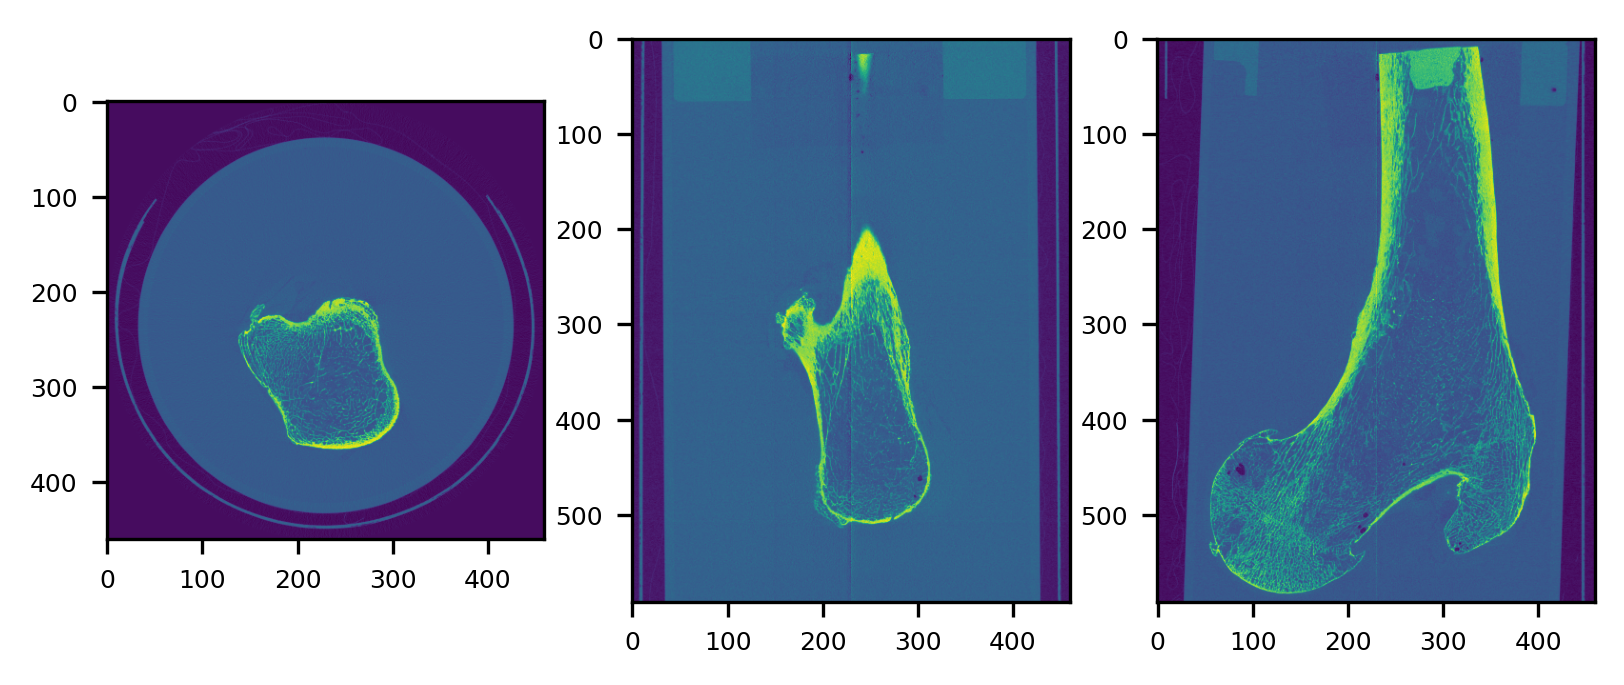

In [16]:
plot_midplanes_sitk(mhd_image)

In [17]:
# print out the usual SimpleITK image characteristics
print (mhd_image.GetSize())
print (mhd_image.GetSpacing())
print (mhd_image.GetOrigin())
print (mhd_image.GetDirection())

(460, 460, 592)
(0.303, 0.303, 0.303)
(0.0, 0.0, 0.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


In [18]:
size_HRpQCT = mhd_image.GetSize()
print("Image size:", size_HRpQCT[0], size_HRpQCT[1], size_HRpQCT[2])
vs_HRpQCT = mhd_image.GetSpacing() # it's a tuple
print("Image spacing:", vs_HRpQCT[0], vs_HRpQCT[1], vs_HRpQCT[2])
dimension = mhd_image.GetDimension()
print("Dimension: ", dimension)

Image size: 460 460 592
Image spacing: 0.303 0.303 0.303
Dimension:  3


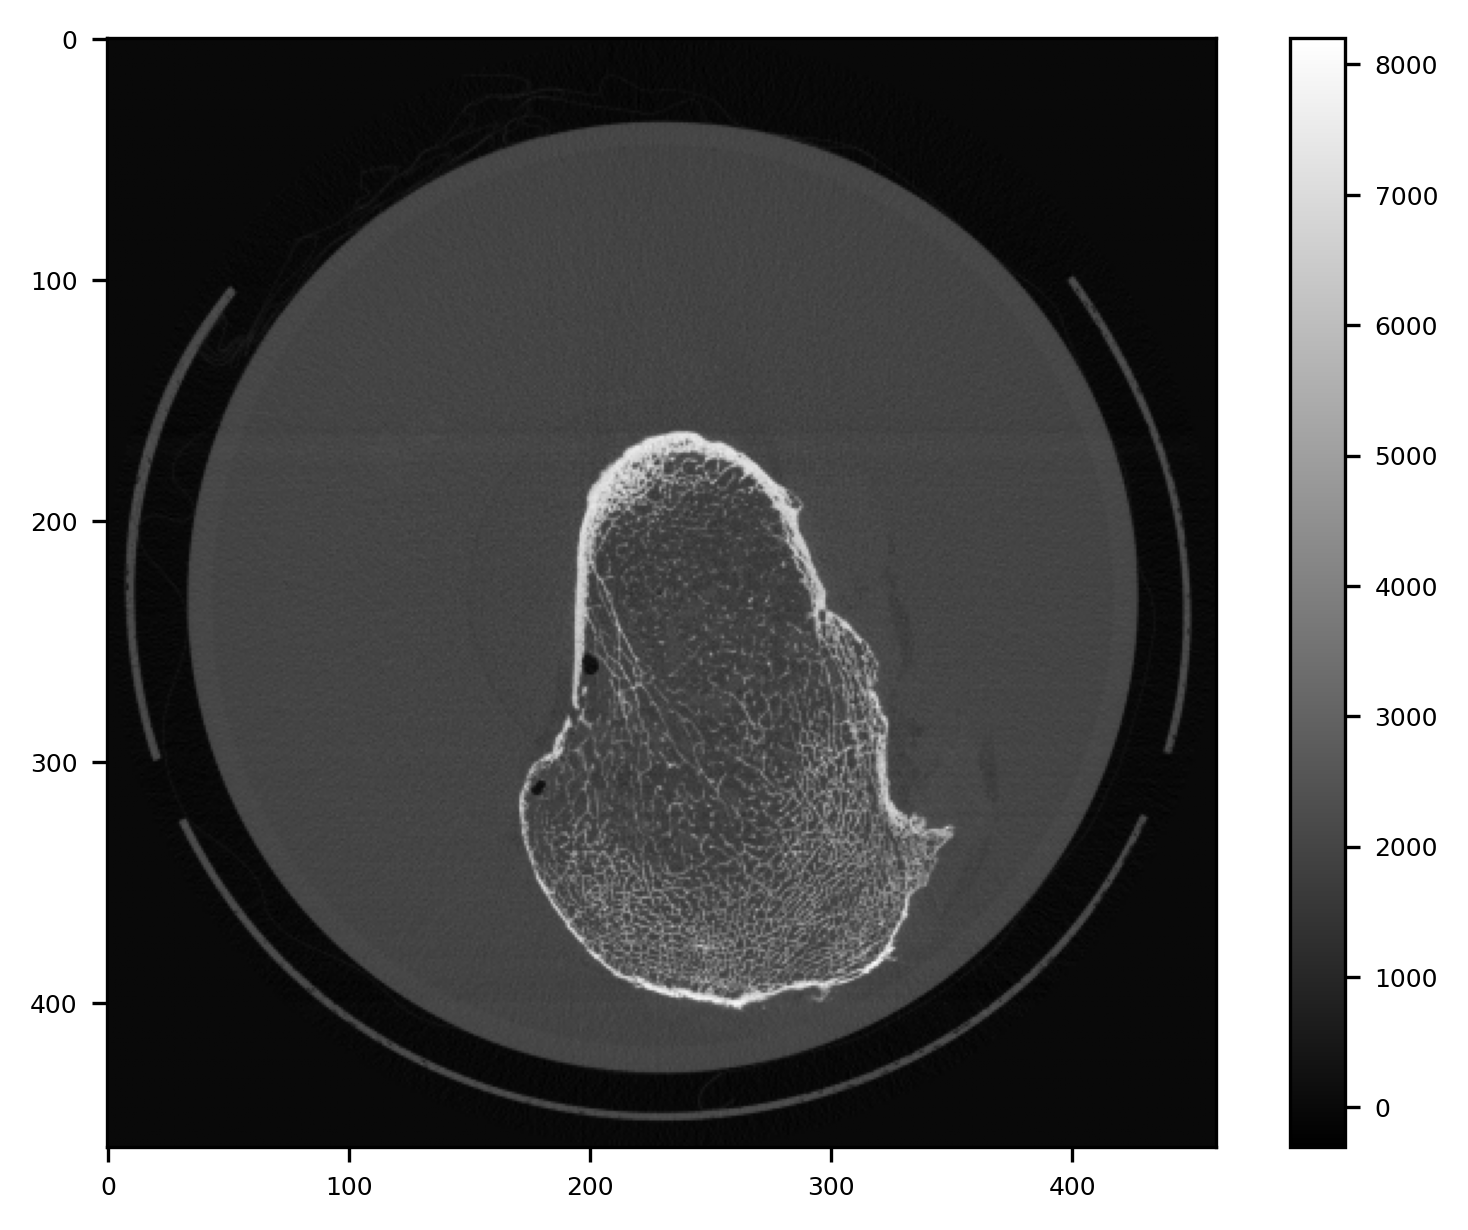

In [12]:
plt.imshow(sitk.GetArrayFromImage(mhd_image)[400,:,:], cmap='grey')
plt.colorbar()

### Median filter
We create a filtered copy of the QCT dataset for segmentation of bone compartments

In [13]:
# filter = sitk.MedianImageFilter()
# filter.SetRadius(1)
# data_3D_QCT_med = filter.Execute(data_3D_QCT_res)

## Bone compartments masks
### Whole bone mask (periosteum mask) with `ORMIR_XCT` `autocontour` method
The method requires 3 parameters for scaling the image to BMD. We should read these parameters from the `.ISQ` file header

In [ ]:
mu_water = 8192 # 0.24090
rescale_slope = 1470 # 1603.51904
rescale_intercept = 3584 # -391.209015

dst_mask, prx_mask, ormir_mask = autocontour(
    mhd_image, mu_water, rescale_slope, rescale_intercept
)

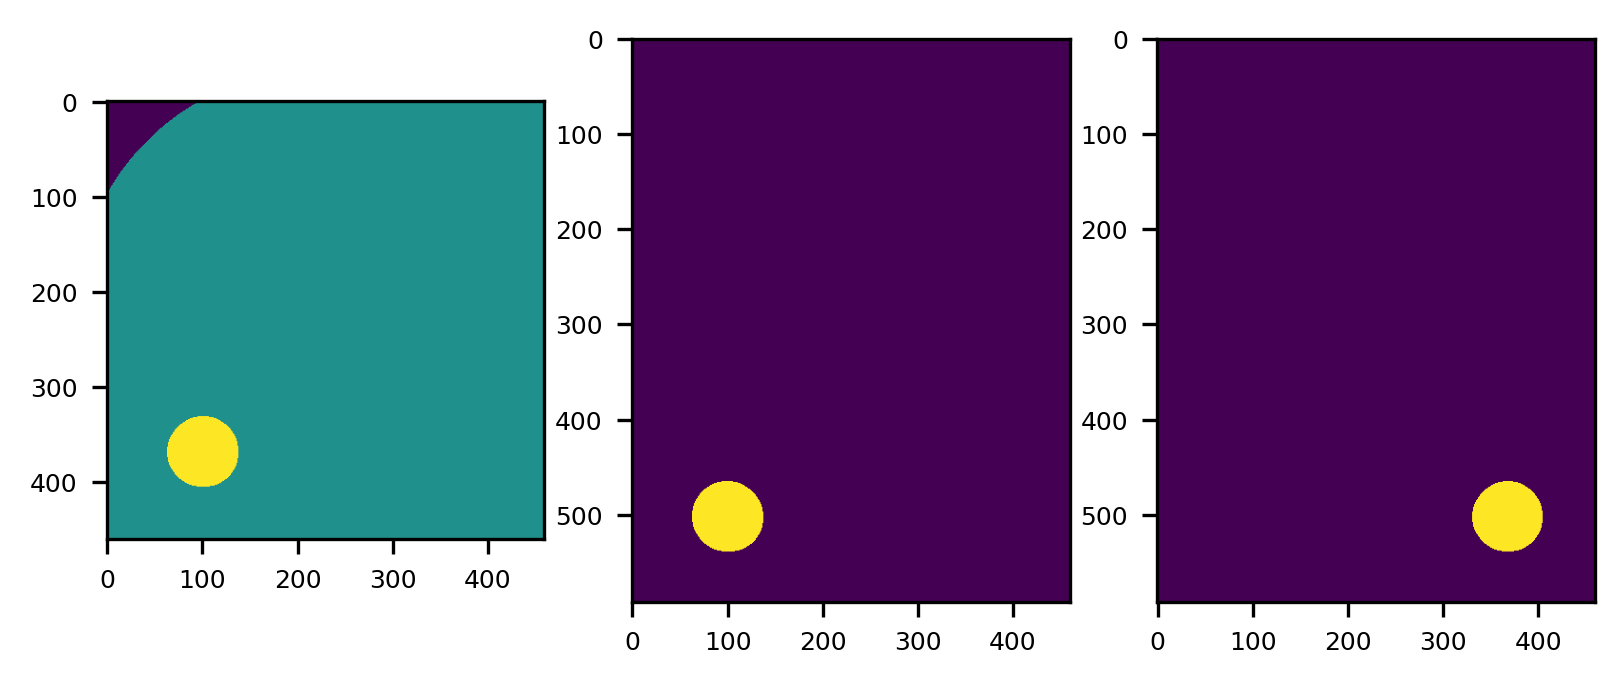

In [14]:
plot_projections_sitk(ormir_mask)

Unfortunately the mask is empty. We should retry after finding the right BMD-calibration parameters

### Periosteum mask with the method inclued in [`recon_utils.imaging_utils`](https://github.com/gianthk/recon_utils)

#### Segment image with multi otsu threshold
Multi-Otsu threshold with 3 materials (backgroud, water, bone)

In [19]:
ts = threshold_multiotsu(sitk.GetArrayFromImage(mhd_image))

#### Get periosteum mask

In [20]:
# data_3D_BW_peri = periosteummask(data_3D>(ts_HR[1]-1000), closepixels=10, closevoxels=10, remove_objects_smaller_than=1, removeunconn=True, verbose=True)
data_3D_QCT_BW_peri = periosteummask(sitk.GetArrayFromImage(mhd_image)>(ts[1]-400), closepixels=5, closevoxels=5, remove_objects_smaller_than=1, removeunconn=True, verbose=True)

100%|██████████| 592/592 [00:11<00:00, 51.46it/s]
/usr/terminus/data-xrm-01/stamplab/users/giiori/code/recon_utils/imaging_utils.py:403: FutureWarning: `cube` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  perimask = morphology.binary_closing(perimask, morphology.cube(closevoxels))


Assign to a new itk image

In [21]:
data_3D_QCT_BW_peri = sitk.GetImageFromArray(data_3D_QCT_BW_peri.astype('uint8'))
data_3D_QCT_BW_peri.CopyInformation(mhd_image)

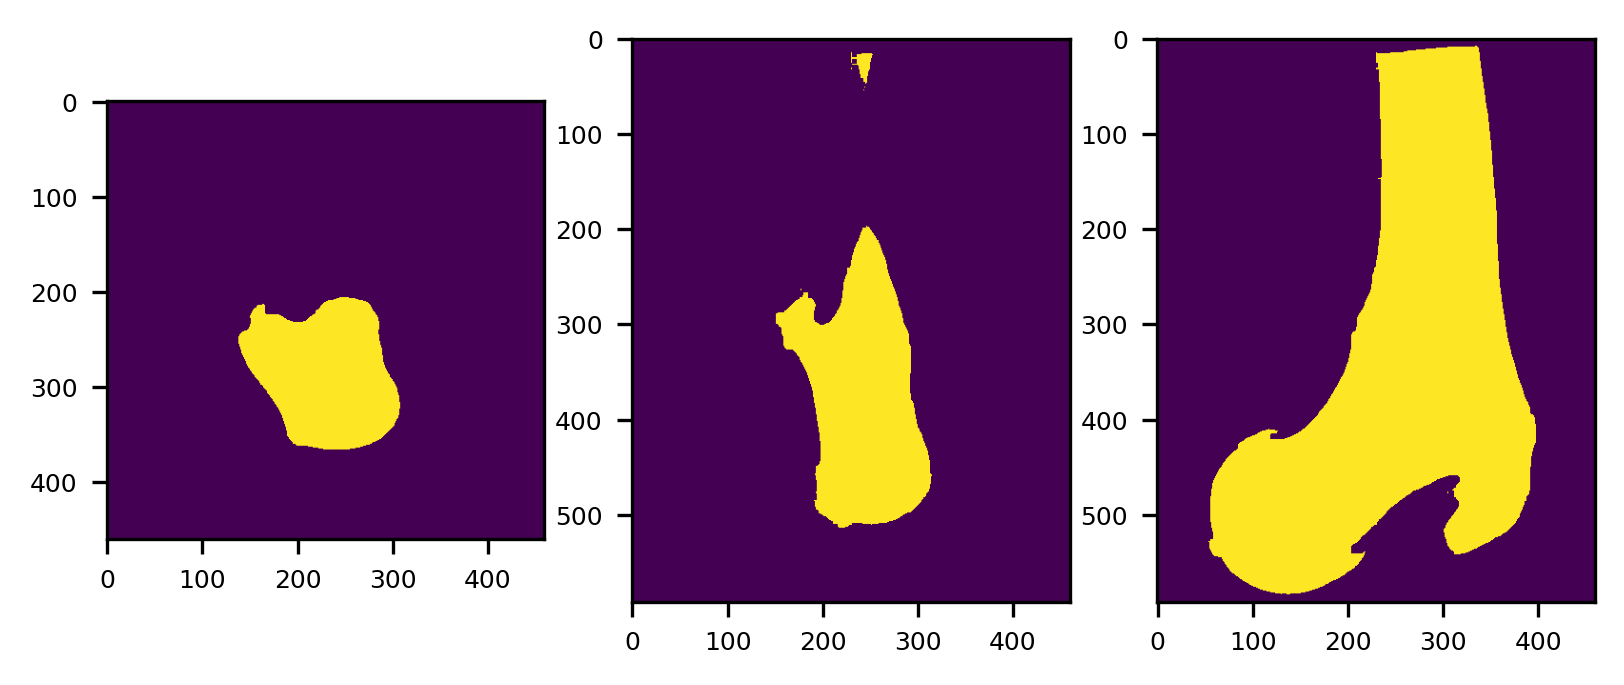

In [22]:
# plot_midplanes_sitk(data_3D_QCT_med>(ts[1])-500)
plot_midplanes_sitk(data_3D_QCT_BW_peri)

### Iterative Voting Hole Filling Filter
Performs the filling operation multiple times until no pixels change, or maximum number of iterations is reached.

In [ ]:
# hole_filling_filter = sitk.VotingBinaryIterativeHoleFillingImageFilter()
# hole_filling_filter.SetRadius(3)
# hole_filling_filter.SetMajorityThreshold(1)
# hole_filling_filter.SetBackgroundValue(0)
# hole_filling_filter.SetForegroundValue(1)
# hole_filled_image = hole_filling_filter.Execute(data_3D_QCT_BW_peri)

In [ ]:
# plot_midplanes_sitk(hole_filled_image)

### Image close

In [ ]:
# closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
# closing_filter.SetKernelRadius(8)
# data_3D_QCT_BW_peri = closing_filter.Execute(hole_filled_image)

In [ ]:
# plot_midplanes_sitk(data_3D_QCT_BW_peri)

#### Write whole bone mask

In [96]:
# need to modify the output path
output_QCT_R_HR_whole_bone = os.path.join(data_dir, 'QCT/QCTFEMUR_2019L/masks/QCTFEMUR_2019L_R_HR_whole_bone.mhd')
os.makedirs(os.path.dirname(output_QCT_R_HR_whole_bone), exist_ok=True)

writer = sitk.ImageFileWriter()
writer.SetFileName(output_QCT_R_HR_whole_bone)
writer.Execute(data_3D_QCT_BW_peri)

### Trabecular bone mask
We erode 5 mm from the surface of the whole bone mask to obtain a tentative mesh of the trabecular core

In [23]:
offset_from_cortex = 3 # mm
kernel_radius = int(offset_from_cortex / data_3D_QCT_BW_peri.GetSpacing()[0])

In [24]:
erode_filter = sitk.BinaryErodeImageFilter()
erode_filter.SetKernelRadius(kernel_radius)
data_3D_BW_trab = erode_filter.Execute(data_3D_QCT_BW_peri)

Delete shaft portion from mask: this is done to remove thin struts and facilitate meshing

In [25]:
tmp = sitk.GetArrayFromImage(data_3D_BW_trab).astype('uint8')
tmp[0:200, :, :] = 0
data_3D_BW_trab = sitk.GetImageFromArray(tmp)
data_3D_BW_trab.CopyInformation(data_3D_QCT_BW_peri)

In [1]:
# myshow(sitk.LabelOverlay(data_3D_QCT, data_3D_BW_trab))

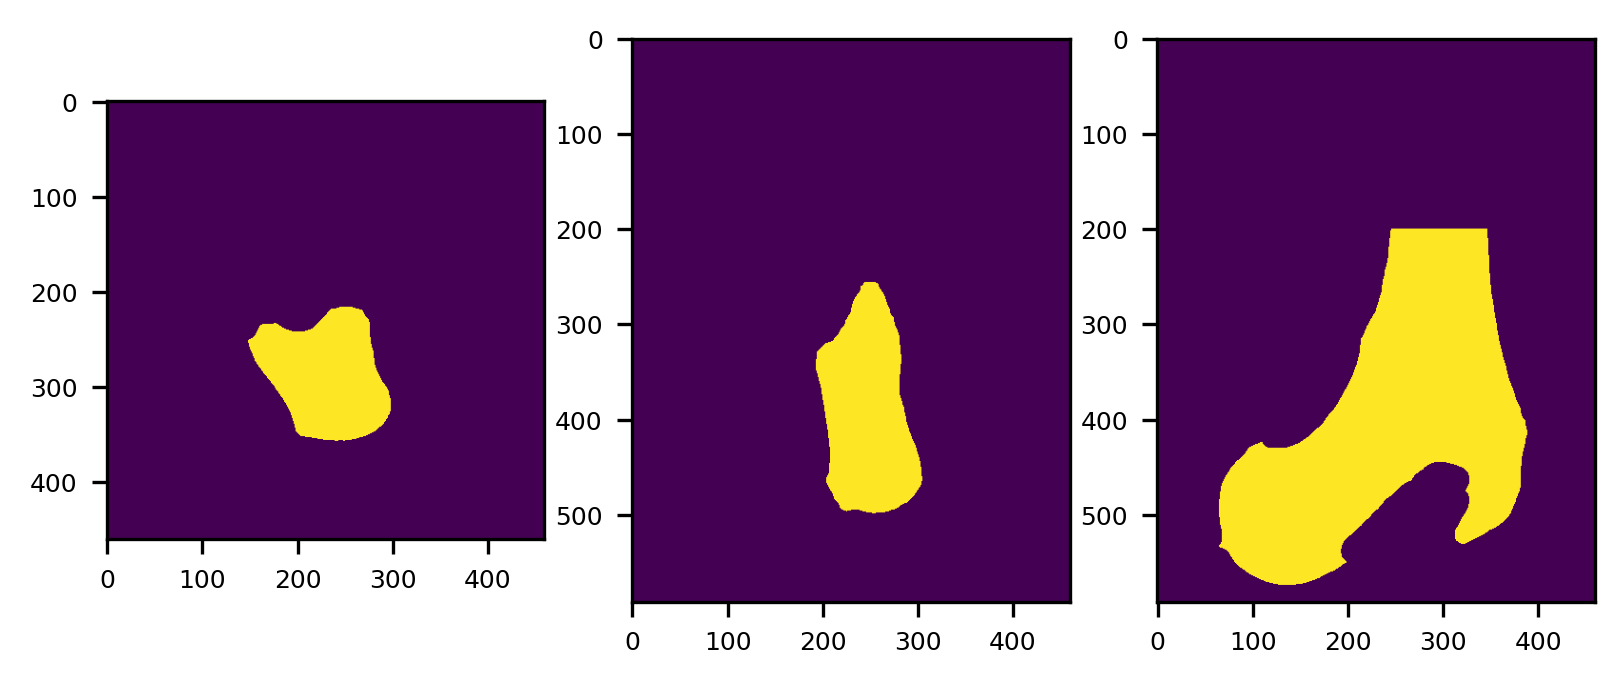

In [26]:
plot_midplanes_sitk(data_3D_BW_trab)

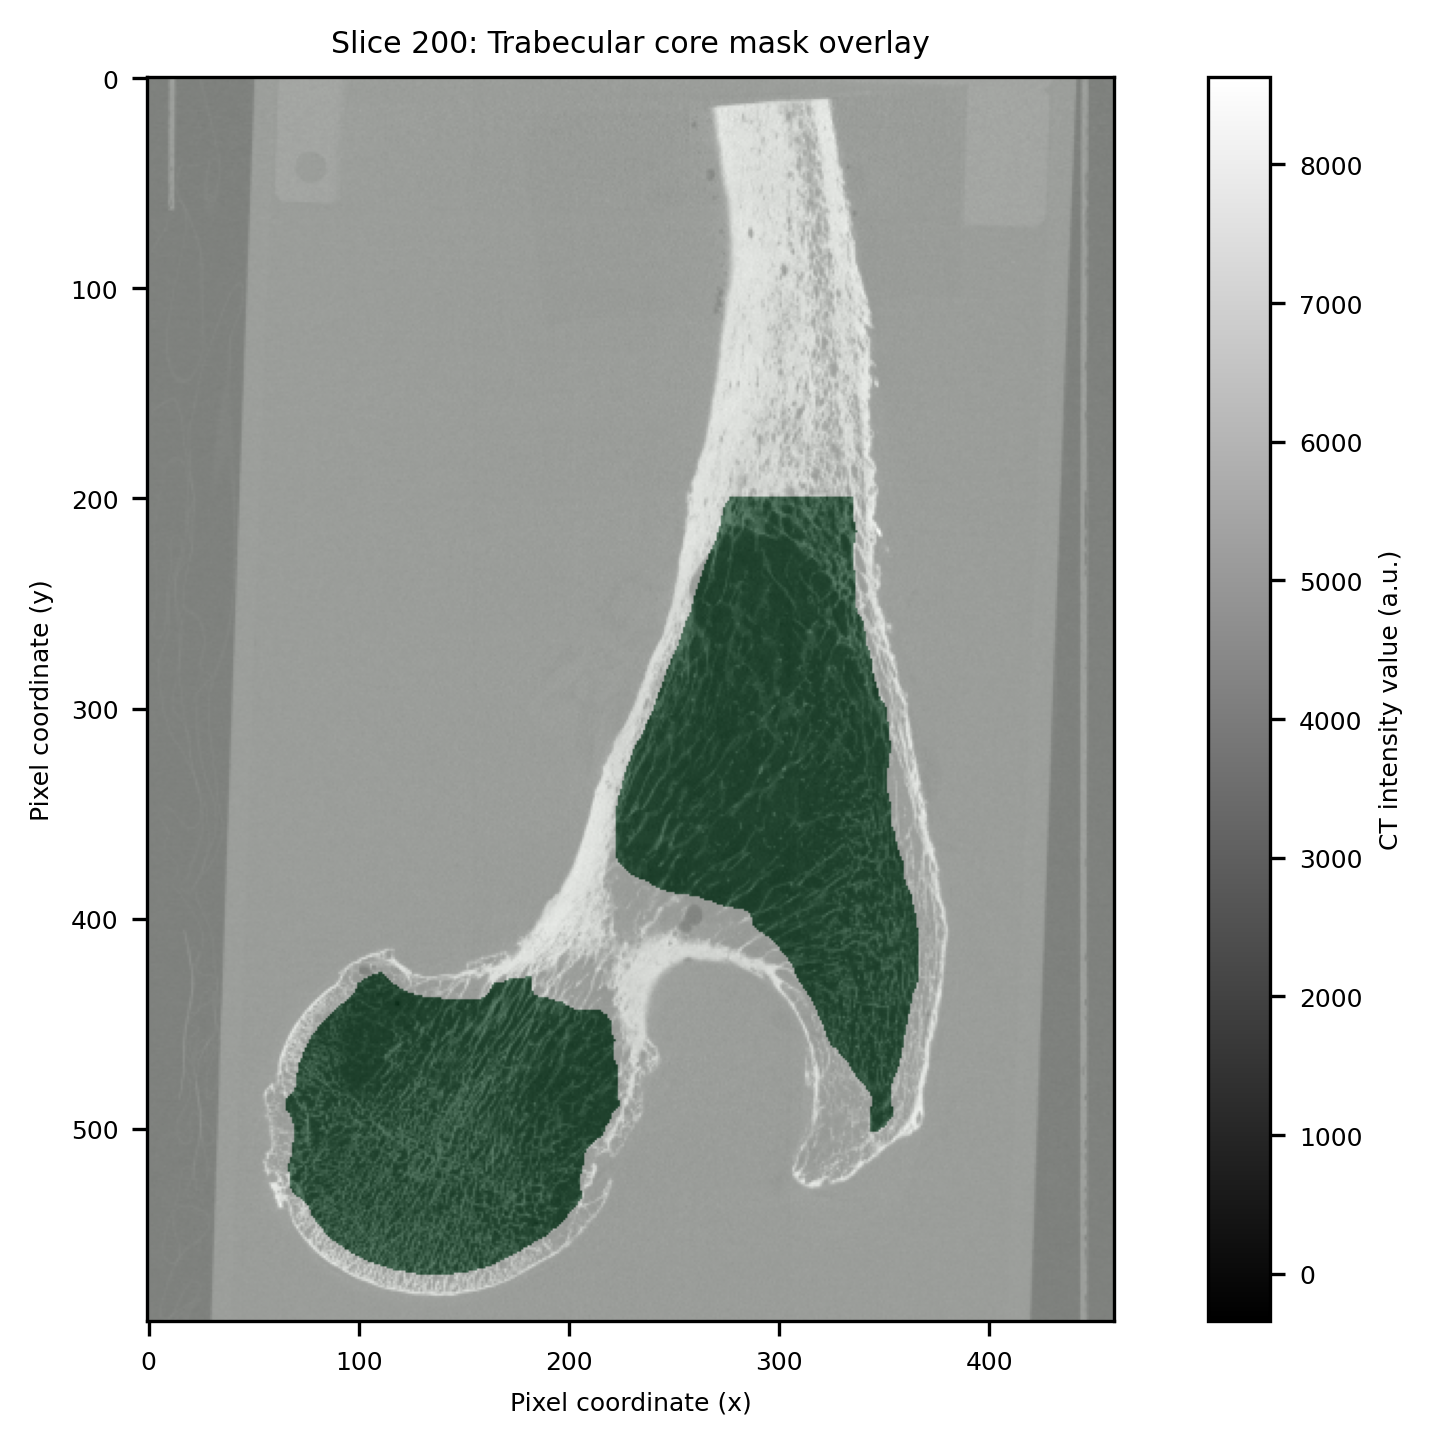

In [ ]:
slice = 200

# Plot the grayscale image
fig, ax = plt.subplots()
im = ax.imshow(sitk.GetArrayFromImage(mhd_image)[:, :, slice], cmap='gray')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('CT intensity value')

# Overlay the green mask
ax.imshow(sitk.GetArrayFromImage(data_3D_BW_trab)[:, :, slice], cmap='Greens', alpha=0.5)  # Adjust alpha for transparency

ax.set_xlabel('Pixel coordinate (x)')
ax.set_ylabel('Pixel coordinate (y)')
ax.set_title(f'Slice {slice}: Trabecular core mask overlay')

# Show the plot
plt.tight_layout()
plt.show()

#### Write trabecular core mask

In [102]:
# need to modify the output path
output_QCT_R_HR_trab = os.path.join(data_dir, 'QCT/QCTFEMUR_2019L/masks/QCTFEMUR_2019L_R_HR_trab.mhd')

writer = sitk.ImageFileWriter()
writer.SetFileName(output_QCT_R_HR_trab)
writer.Execute(data_3D_BW_trab)

---
# scratch: